# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

**Задача:** построить модель для определения стоимости. 

*Условия*:
1. Оценка качества моделей метрикой RMSE;
2. Значение метрики RMSE должно быть меньше 2500.

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.



# План работы

1. Первичная обработка данных;
2. Подготовка выборок;
3. Обучение моделей;
4. Анализ времени обучения, времени предсказания и качества моделей;
5. Проверка лучшей модели на качество.


# Описание данных

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.
Скачать датасет: https://code.s3.yandex.net/datasets/autos.csv


*Признаки:*

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

*Целевой признак:*

Price — цена (евро)

## Подключение необходимых библиотек

In [82]:
!pip install pandas_profiling sweetviz

In [83]:
import os
import pandas as pd
import numpy as np
import warnings
import lightgbm as lgb
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from catboost import CatBoostRegressor
from scipy.stats import uniform as sp_randFloat 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from pandas_profiling import ProfileReport
import random
import sweetviz as sv
from IPython.display import IFrame

### Игнорируем предупреждения

In [84]:
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

### Объявление констант

In [85]:
RS = 12345
CV = 3

## Подготовка данных

### Знакомство с данными

In [86]:
pth_1 = r'C:\Users\Елена Тюлькина\Downloads\autos.csv'
pth_2 = 'autos.csv'

if os.path.exists(pth_1):
    df_autos = pd.read_csv(pth_1)
elif os.path.exists(pth_2):
    df_autos = pd.read_csv(pth_2)
else:
    df_autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [87]:
def hello_data(data):
    
    display(data.head(5))
    
    print(data.info())
    
    print(data.describe())
    
    print('Дубликатов в таблице:', data.duplicated().sum())
    
    print('Форма таблицы:{}'.format(data.shape))
    
    data.hist(figsize=(15, 20));
    
    return (data.isna().mean()*100).sort_values(ascending=False).to_frame().rename(
    columns = {0:'Процент_пропусков'}).style.background_gradient('coolwarm').format("{:.1f}")

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Процент_пропусков
Repaired,20.1
VehicleType,10.6
FuelType,9.3
Gearbox,5.6
Model,5.6
DateCrawled,0.0
Price,0.0
RegistrationYear,0.0
Power,0.0
Kilometer,0.0


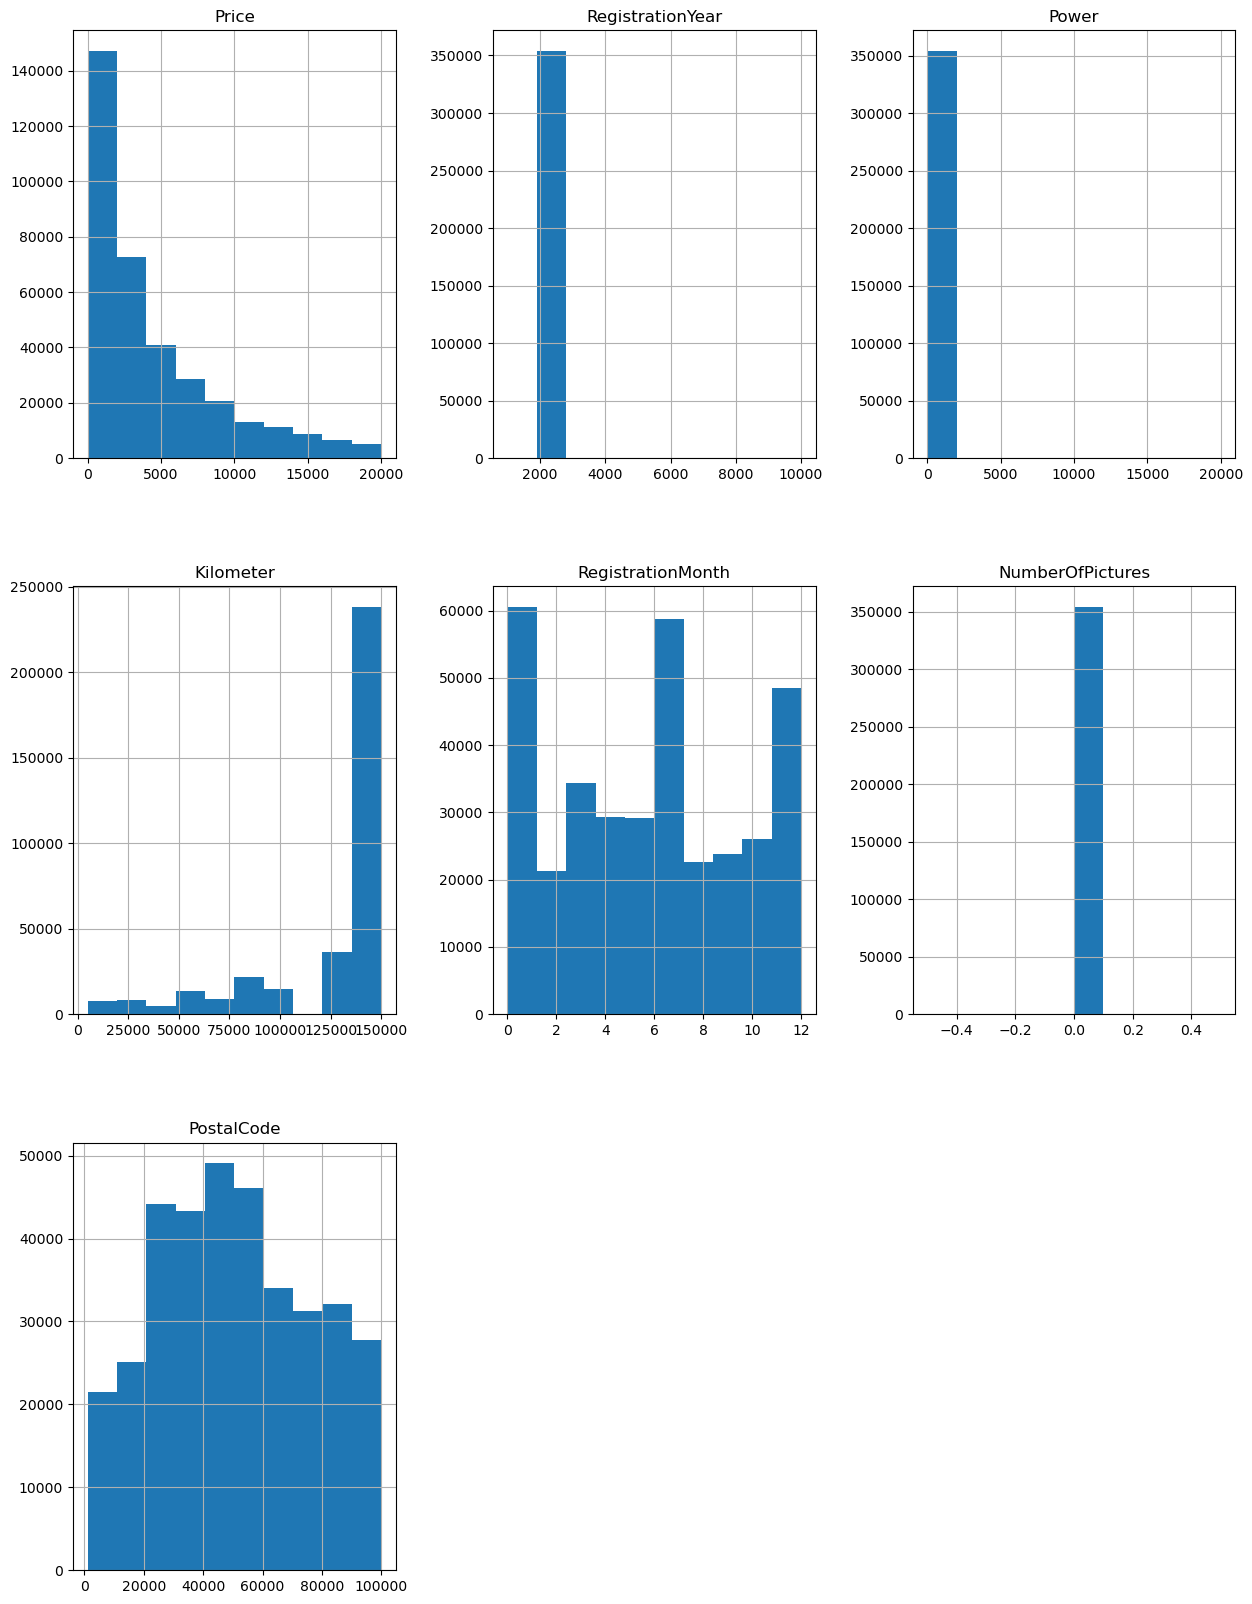

In [88]:
hello_data(df_autos)

<AxesSubplot: >

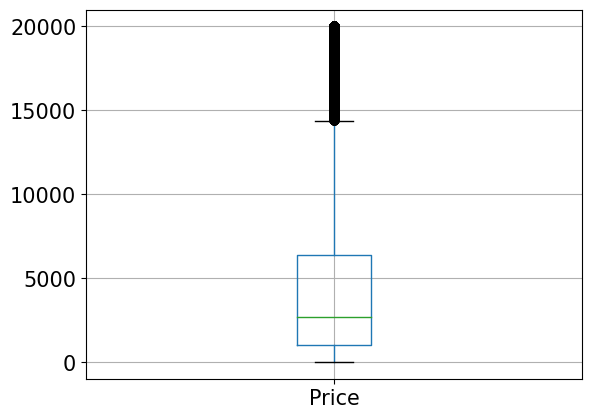

In [89]:
df_autos.boxplot(column='Price', grid=True, fontsize=15)

<AxesSubplot: >

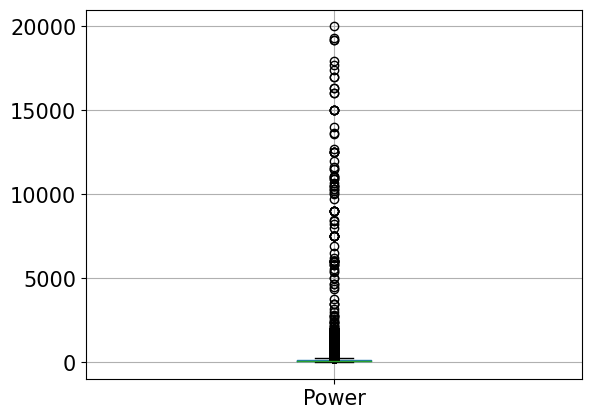

In [90]:
df_autos.boxplot(column='Power', grid=True, fontsize=15)

Максимум лошадиных сил на сегодняшний день - 2028 (Dagger GT компании TranStar Racing LLC). На графике видны явные аномалии в виде неземных высоких мощностей.

<AxesSubplot: >

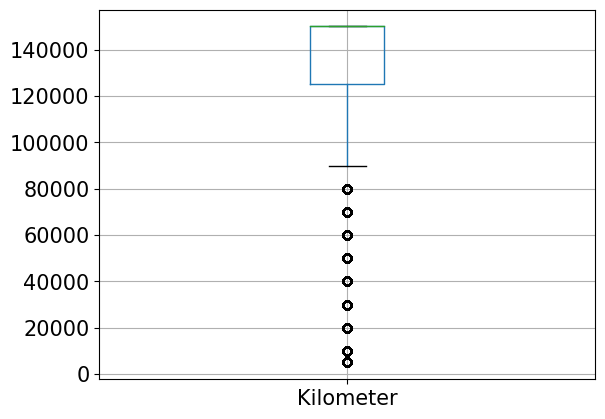

In [91]:
df_autos.boxplot(column='Kilometer', grid=True, fontsize=15)

<AxesSubplot: >

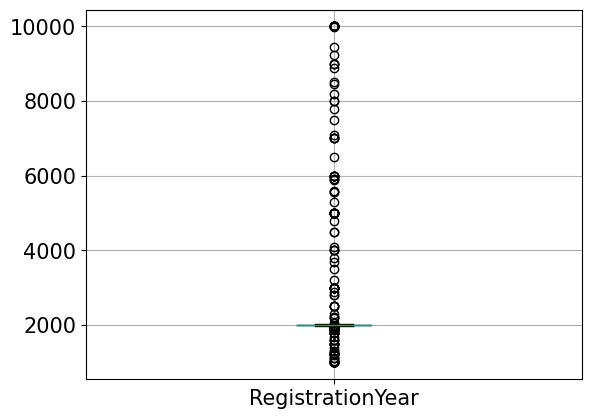

In [92]:
df_autos.boxplot(column='RegistrationYear', grid=True, fontsize=15)

Путешествуем в будущее: в 2023г у нас есть данные из 10000г :)

**По первичному взгляду на данные увидели следующие проблемы:**
1. Пропуски в 5 столбцах;
2. Типы данных не соответствующие: DateCrawled, DateCreated, LastSeen - тип object. Более того, в обучении модели данные признаки будут не информативными;
3. 4 дубликата;
4. Все нулевые значения в стоблце с кол-вом картинок;
5. Аномальные значения в столбцах RegistrationYear и Power;
6. В столбце RegistrationMonth месяца 0-12, а должно быть 1-12.

Точек данных = 354369, признаков = 16.

### Предобработка данных

#### Редактируем названия столбцов

In [93]:
df_autos.columns = df_autos.columns.str.lower()

In [94]:
df_autos.rename(columns={'datecrawled':'date_crawled', 'vehicletype':'vehicle_type', 
                        'registrationyear':'reg_year', 'registrationmonth':'reg_month',
                        'fueltype':'fuel_type', 'datecreated':'date_created',
                        'numberofpictures':'n_of_pictures', 'lastseen':'last_seen'}, inplace=True)

In [95]:
df_autos.tail()

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,kilometer,reg_month,fuel_type,brand,repaired,date_created,n_of_pictures,postalcode,last_seen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


#### Обработка выбросов и аномалий

**Столбец price**

<AxesSubplot: >

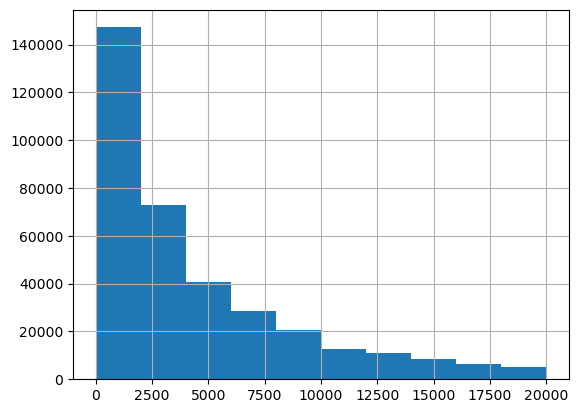

In [96]:
df_autos['price'].hist()

In [97]:
df_autos['price'].describe(percentiles=[.045, .1, .75, .96])

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
4.5%        150.000000
10%         499.000000
50%        2700.000000
75%        6400.000000
96%       15499.000000
max       20000.000000
Name: price, dtype: float64

Слишком высокие и низкие значения могут быть выбросами: на нескольких сайтах по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом.
Поставим ограничения в 0.045 и в 0.96 квантили.

In [98]:
drop_price = df_autos[
    (df_autos['price'] < df_autos['price'].quantile(.045)) | (df_autos['price'] > df_autos['price'].quantile(.96))
]
drop_price.shape

(29025, 16)

In [99]:
df_autos.drop(drop_price.index, inplace=True)

**Столбец kilometer**

Следует избавиться от сильно низких значений, тк по боксплоту выше это скорее выбросы.

In [100]:
df_autos['kilometer'].describe(percentiles=[.013, .1, .75, .95])

count    325344.000000
mean     130108.900118
std       35883.670248
min        5000.000000
1.3%       5000.000000
10%       70000.000000
50%      150000.000000
75%      150000.000000
95%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [101]:
drop_km = df_autos[
    df_autos['kilometer'] < df_autos['kilometer'].quantile(.013)
]
drop_km.shape

(0, 16)

In [102]:
df_autos.drop(drop_km.index, inplace=True)

**Столбец reg_year**

In [103]:
df_autos['reg_year'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016, 2007,
       2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2011,
       1982, 1976, 1973, 2015, 1969, 1971, 1987, 1983, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 3200, 1000, 1941,
       9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000, 2066,
       1949, 2019, 1937, 1951, 1800, 1959, 1954, 1234, 5300, 9000, 2900,
       6000, 1953, 5900, 5911, 1400, 5000, 1950, 4000, 1952, 8500, 3700,
       3800, 4800, 1942, 7000, 1956, 1935, 1936, 1923, 2290, 1930, 1001,
       9450, 1944, 2500, 1938, 1934, 1943, 1928, 5555, 5600, 1600, 1111,
       1932, 1039, 2800, 1931, 1948, 4500, 1602, 7800, 7100, 1300, 8200,
       1946], dtype=int64)

In [104]:
check = ['2017', '2018', '2019', '2020', '2021', '2022']

for i in check:
    if i in df_autos['date_created']:
        print(f'{i} exist')
    else:
        print('Wrong data')

Wrong data
Wrong data
Wrong data
Wrong data
Wrong data
Wrong data


Похоже, что крайний год создания анкет - 2016. Возьмём для дальнейшей работы промежуток

In [105]:
df_autos = df_autos.query('reg_year > 1910 & reg_year < 2017')

In [106]:
df_autos['reg_year'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007, 2009,
       2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006, 1999, 2012,
       2010, 2000, 1992, 2013, 1996, 1985, 1989, 2011, 1982, 1976, 1973,
       2015, 1969, 1971, 1987, 1983, 1988, 1980, 1970, 1986, 1965, 1945,
       1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1966, 1975,
       1963, 1964, 1960, 1958, 1967, 1941, 1962, 1929, 1957, 1940, 1949,
       1937, 1951, 1959, 1954, 1953, 1950, 1952, 1942, 1956, 1935, 1936,
       1923, 1930, 1944, 1938, 1934, 1943, 1928, 1932, 1931, 1948, 1946],
      dtype=int64)

**Столбец power**

In [107]:
power = df_autos.query('power > 2028')

In [108]:
power['power'].count()

87

Тк больших значений мало, можем их просто удалить.

In [109]:
df_autos = df_autos.query('power <= 2028')

In [110]:
df_autos['power'].value_counts()

0       30581
75      21851
60      14484
150     13194
101     12362
        ...  
1937        1
850         1
700         1
612         1
1241        1
Name: power, Length: 573, dtype: int64

<AxesSubplot: >

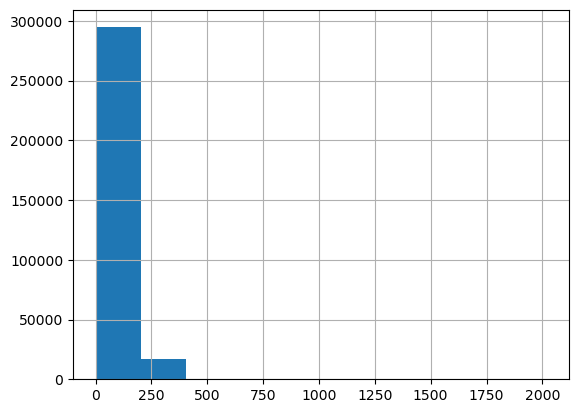

In [111]:
df_autos['power'].hist()

40 тысяч строк с нулевым кол-вом лошадиных сил. Заменим нули на медианное значение по типу автомобильного кузова - так мы сможем получить правдоподобное значение

In [112]:
df_autos.vehicle_type.value_counts()

sedan          85050
small          76208
wagon          60623
bus            26916
convertible    18001
coupe          13951
suv             9865
other           2950
Name: vehicle_type, dtype: int64

In [113]:
for t in df_autos['vehicle_type'].unique():
    df_autos.loc[(df_autos['vehicle_type'] == t) & (df_autos['power'] == 0) | (df_autos['power'] == 0.0), 'power'] = \
    df_autos.loc[(df_autos['vehicle_type'] == t), 'power'].median()

In [114]:
df_autos['power'].value_counts()

75.0      21851
60.0      14484
150.0     13194
101.0     12362
90.0      11579
          ...  
1937.0        1
850.0         1
700.0         1
612.0         1
1241.0        1
Name: power, Length: 572, dtype: int64

In [115]:
df_autos['power'].min()

1.0

<AxesSubplot: >

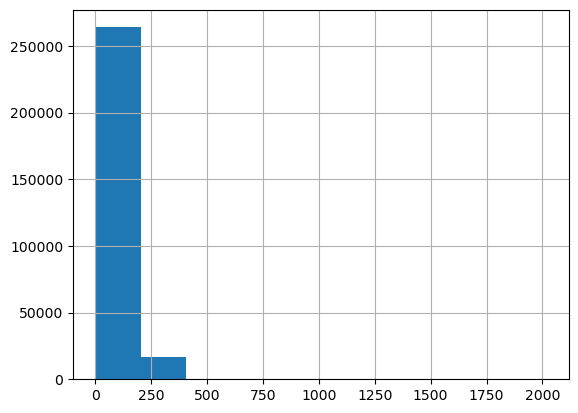

In [116]:
df_autos['power'].hist()

#### Обработка пропусков

**Столбец power**

In [117]:
df_autos['power'].isna().sum()

30581

In [118]:
for t in df_autos['vehicle_type'].unique():
    df_autos.loc[(df_autos['vehicle_type'] == t) & (df_autos['power'].isna()), 'power'] = \
    df_autos.loc[(df_autos['vehicle_type'] == t), 'power'].median()

In [119]:
df_autos['power'].isna().sum()

7617

<AxesSubplot: >

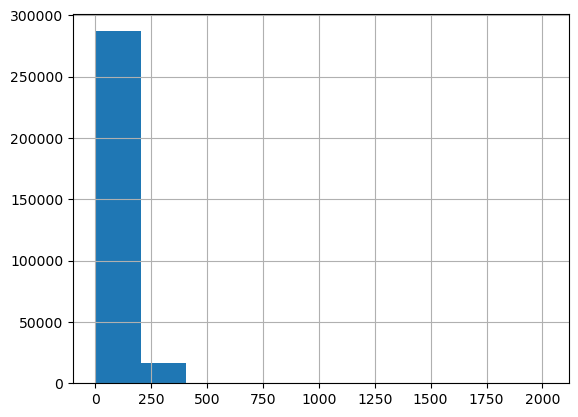

In [120]:
df_autos['power'].hist()

Это примерно 4% от общих данных, дабы максимально не заполнять медианой данный столбец, предлагаю оставшиеся пропуски просто удалить

**Столбец repaired**

Мы не можем быть точно уверены,что пропуски в данных от того, что машина не была в ремонте, и вместо того чтобы поставить *нет*, просто пропускали этот признак. Возможно, что машина в ремонте была и это намеренно скрыли. Чтобы не терять большое количество данных, поставим заглушку *неизвестно*

In [121]:
df_autos['repaired'].value_counts()

no     223390
yes     31642
Name: repaired, dtype: int64

In [122]:
df_autos['repaired'].fillna('unknown', inplace=True)

In [123]:
df_autos['repaired'].value_counts()

no         223390
unknown     56705
yes         31642
Name: repaired, dtype: int64

**Столбцы vehicle_type, gearbox, model, fuel_type**

Если мы сгруппируем столбцы по бренду, модели, типу коробки передач, типу кузова, то тип топлива будет различаться; и так со всеми остальными столбцами. Так, данные не восстановить, тоже поставим заглушку

In [124]:
df_autos['vehicle_type'].fillna('unknown', inplace=True)

In [125]:
df_autos['gearbox'].fillna('unknown', inplace=True)

In [126]:
df_autos['model'].fillna('unknown', inplace=True)

In [127]:
df_autos['fuel_type'].fillna('unknown', inplace=True)

In [128]:
df_autos = df_autos.dropna(axis=0, inplace=False)

#### Добавим столбец

В датафрейме разный возраст машин. Возможно такое, что для разных возрастов - своё ценообразование. Введём фактор *тип возраста*.

Пусть будут следующие группы:

Vintage (1910-1929)

Classic (1930-1949)

Post-War (1950-1969)

Muscle (1960-1979)

Modern (1980-1999)

New Millennium (2000-Current)


Чтобы работать с возрастом машины, необходимо привести столбец 'reg_year' к типу datetime.

In [129]:
def categorize_age(year):
    if year >= 1910 and year <= 1929:
        return 'Vintage'
    elif year >= 1930 and year <= 1949:
        return 'Classic'
    elif year >= 1950 and year <= 1969:
        return 'Post-War'
    elif year >= 1960 and year <= 1979:
        return 'Muscle'
    elif year >= 1980 and year <= 1999:
        return 'Modern'
    elif year >= 2000:
        return 'New Millennium'
    else:
        return "unknown"

In [130]:
df_autos['age_category'] = df_autos['reg_year'].apply(categorize_age)

<AxesSubplot: >

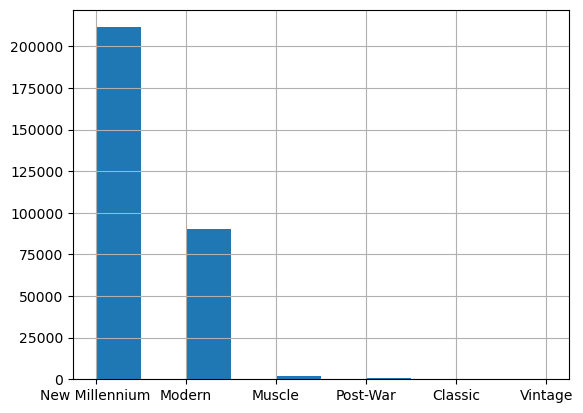

In [131]:
df_autos['age_category'].hist()

*Шалость удалась*

**Проверим изменения после предобработки данных**


,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,kilometer,reg_month,fuel_type,brand,repaired,date_created,n_of_pictures,postalcode,last_seen,age_category
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,New Millennium
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,New Millennium
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,New Millennium
5,2016-04-04 17:36:23,650,sedan,1995,manual,102.0,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,Modern
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109.0,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,New Millennium


<class 'pandas.core.frame.DataFrame'>
Int64Index: 304120 entries, 2 to 354368
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date_crawled   304120 non-null  object 
 1   price          304120 non-null  int64  
 2   vehicle_type   304120 non-null  object 
 3   reg_year       304120 non-null  int64  
 4   gearbox        304120 non-null  object 
 5   power          304120 non-null  float64
 6   model          304120 non-null  object 
 7   kilometer      304120 non-null  int64  
 8   reg_month      304120 non-null  int64  
 9   fuel_type      304120 non-null  object 
 10  brand          304120 non-null  object 
 11  repaired       304120 non-null  object 
 12  date_created   304120 non-null  object 
 13  n_of_pictures  304120 non-null  int64  
 14  postalcode     304120 non-null  int64  
 15  last_seen      304120 non-null  object 
 16  age_category   304120 non-null  object 
dtypes: float64(1), int64(6), obje

,Процент_пропусков
date_crawled,0.0
fuel_type,0.0
last_seen,0.0
postalcode,0.0
n_of_pictures,0.0
date_created,0.0
repaired,0.0
brand,0.0
reg_month,0.0
price,0.0


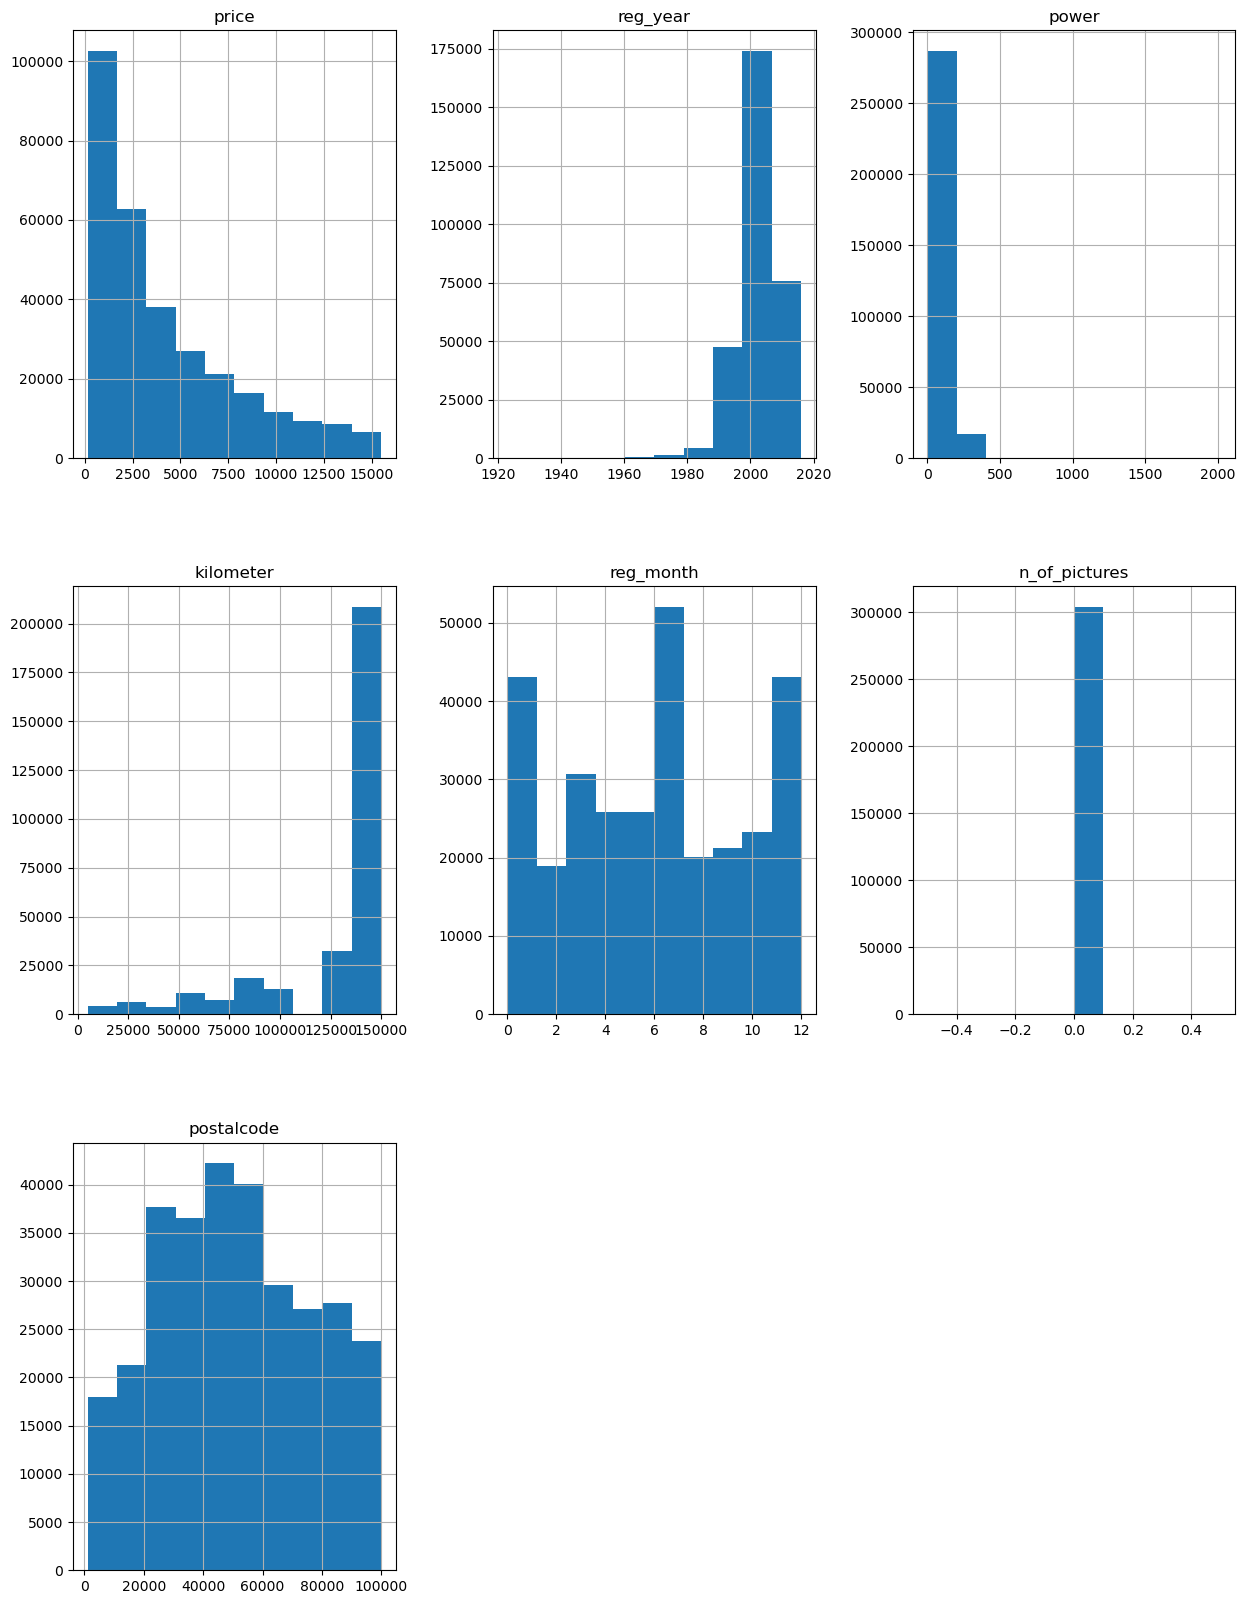

In [132]:
hello_data(df_autos)

**Промежуточный итог:**

Привели данные в удобный для работы вид: там, где это возможно, заполнили пропуски, где нет - поставили заглушки, а также избавились от выбросов и аномалий.

### Подготовка выборок

In [133]:
non_informative = ['date_crawled', 'date_created', 'n_of_pictures', 'last_seen', 'postalcode', 'reg_month']

Даты лишь перегрузят обучение модели, а кол-во картинок и код не влияют на цену авто. Также как и месяц регистрации - при покупке обычно смотрят на год

In [134]:
autos = df_autos.drop(non_informative, axis=1)

In [135]:
categorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'age_category']

In [136]:
numeric = ['price', 'power']

**Разбитие данных на выборки**

In [137]:
# выделим признаки

target = autos['price']
features = autos.drop('price', axis=1)

In [138]:
# разобьём данные

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=RS)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=RS)

In [139]:
features_train.shape, features_valid.shape, features_test.shape

((182472, 10), (60824, 10), (60824, 10))

In [140]:
target_train.shape, target_valid.shape, target_test.shape

((182472,), (60824,), (60824,))

**Кодировка данных**

In [141]:
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

In [142]:
features_train_oe = features_train.copy()
features_valid_oe = features_valid.copy()
features_test_oe = features_test.copy()

In [143]:
features_train_oe = oe.fit_transform(features_train_oe)
features_valid_oe = oe.transform(features_valid_oe)
features_test_oe = oe.transform(features_test_oe)

In [144]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [145]:
features_train_ohe = features_train.copy()
features_valid_ohe = features_valid.copy()
features_test_ohe = features_test.copy()

In [146]:
ohe.fit(features_train_ohe)

OneHotEncoder(handle_unknown='ignore')

In [147]:
features_train_ohe = ohe.transform(features_train_ohe)
features_valid_ohe = ohe.transform(features_valid_ohe)
features_test_ohe = ohe.transform(features_test_ohe)

## Обучение моделей

In [148]:
def RMSE(target, predict):
    RMSE = mean_squared_error(target, predict) ** 0.5
    return RMSE

In [149]:
score = make_scorer(RMSE, greater_is_better=False)

In [150]:
def show_feature_imp(imp_name, model_name):
    imp_name = model_name.feature_importances_

    for i,v in enumerate(imp_name):
        print('Feature: %0d, Score: %.5f' % (i,v))

    pyplot.bar([x for x in range(len(imp_name))], imp_name)
    
    return pyplot.show()

### LinearRegression

In [151]:
LR_model = LinearRegression()

In [152]:
%%time
LR_model.fit(features_train_ohe, target_train)

CPU times: total: 10.6 s
Wall time: 8.04 s


LinearRegression()

In [153]:
%%time
LR_model_predictions = LR_model.predict(features_valid_ohe)

CPU times: total: 0 ns
Wall time: 3.52 ms


In [154]:
LR_model_rmse = RMSE(target_valid, LR_model_predictions)
    
print('RMSE:', LR_model_rmse)

RMSE: 1686.9393987569108


Высокая скорость обучения и предсказания и приемлемы результат метрики.

In [155]:
importance_lr = LR_model.coef_

In [156]:
# summarize feature importance

for i,v in enumerate(importance_lr):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -46.26637
Feature: 1, Score: 1161.18303
Feature: 2, Score: -11.81318
Feature: 3, Score: -164.56055
Feature: 4, Score: -301.69369
Feature: 5, Score: -324.53014
Feature: 6, Score: 982.85680
Feature: 7, Score: -851.93253
Feature: 8, Score: -443.24336
Feature: 9, Score: 4254.00912
Feature: 10, Score: -7321.71130
Feature: 11, Score: 2050.29236
Feature: 12, Score: 2973.71208
Feature: 13, Score: -1265.11941
Feature: 14, Score: -3120.83010
Feature: 15, Score: 2534.30960
Feature: 16, Score: -486.47360
Feature: 17, Score: 1592.81083
Feature: 18, Score: 6456.92696
Feature: 19, Score: 1491.97599
Feature: 20, Score: -744.65048
Feature: 21, Score: -1254.42582
Feature: 22, Score: -3535.04224
Feature: 23, Score: -859.68744
Feature: 24, Score: -5593.35480
Feature: 25, Score: 6598.49139
Feature: 26, Score: -907.26460
Feature: 27, Score: -1021.38793
Feature: 28, Score: 2754.20899
Feature: 29, Score: 64.85021
Feature: 30, Score: 1937.61963
Feature: 31, Score: -748.52779
Feature: 32, Sco

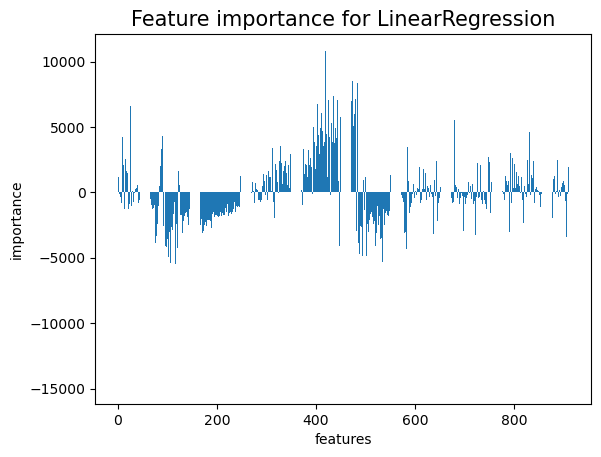

In [157]:
#  feature importance
pyplot.bar([x for x in range(len(importance_lr))], importance_lr)


plt.title(label='Feature importance for LinearRegression', fontsize=15)    
plt.ylabel('importance', fontsize=10)
plt.xlabel('features', fontsize=10)

pyplot.show()

### Catboost

In [158]:
Catboost_model = CatBoostRegressor(loss_function='RMSE')

In [159]:
Catboost_params = {'iterations': [100, 150, 200],
                   'learning_rate': [0.03, 0.1],
                   'depth': [2, 4, 6, 8],
                   'l2_leaf_reg': [0.2, 0.5, 1, 3]}

In [160]:
Catboost_RS = RandomizedSearchCV(
    Catboost_model, param_distributions=Catboost_params, cv=CV, scoring='neg_root_mean_squared_error', n_jobs=-1
)

In [161]:
%%time
Catboost_RS.fit(features_train, target_train, cat_features=categorical, verbose=50)

0:	learn: 3492.0512872	total: 524ms	remaining: 1m 44s
50:	learn: 1593.6485858	total: 17.4s	remaining: 51s
100:	learn: 1514.3819142	total: 31.5s	remaining: 30.8s
150:	learn: 1476.5332674	total: 49.3s	remaining: 16s
199:	learn: 1450.5090785	total: 1m 8s	remaining: 0us
CPU times: total: 2min 40s
Wall time: 10min 39s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000216AA49CFD0>,
                   n_jobs=-1,
                   param_distributions={'depth': [2, 4, 6, 8],
                                        'iterations': [100, 150, 200],
                                        'l2_leaf_reg': [0.2, 0.5, 1, 3],
                                        'learning_rate': [0.03, 0.1]},
                   scoring='neg_root_mean_squared_error')

In [162]:
Catboost_RS.best_params_

{'learning_rate': 0.1, 'l2_leaf_reg': 0.2, 'iterations': 200, 'depth': 6}

In [163]:
Catboost_model = CatBoostRegressor(
    loss_function='RMSE', iterations=200, learning_rate=0.1, depth=8, l2_leaf_reg=3
)

In [164]:
%%time
Catboost_model.fit(features_train, target_train, cat_features=categorical, verbose=50)

0:	learn: 3479.3522926	total: 599ms	remaining: 1m 59s
50:	learn: 1535.8601812	total: 21s	remaining: 1m 1s
100:	learn: 1459.8928001	total: 44.8s	remaining: 43.9s
150:	learn: 1415.9328000	total: 1m 13s	remaining: 23.7s
199:	learn: 1388.9148188	total: 1m 38s	remaining: 0us
CPU times: total: 3min 58s
Wall time: 1min 40s


In [165]:
%%time
Catboost_model_predictions = Catboost_model.predict(features_valid)

CPU times: total: 547 ms
Wall time: 534 ms


In [166]:
Catboost_model_rmse = RMSE(target_valid, Catboost_model_predictions)
    
print('RMSE:', Catboost_model_rmse)

RMSE: 1420.3906595506958


Хорошая скорость предсказаний и обучения и удовлетворяющие результаты по метрике.

Feature: 0, Score: 9.64861
Feature: 1, Score: 37.61040
Feature: 2, Score: 1.03930
Feature: 3, Score: 20.04822
Feature: 4, Score: 4.19199
Feature: 5, Score: 8.33785
Feature: 6, Score: 1.38454
Feature: 7, Score: 10.38798
Feature: 8, Score: 3.72276
Feature: 9, Score: 3.62835


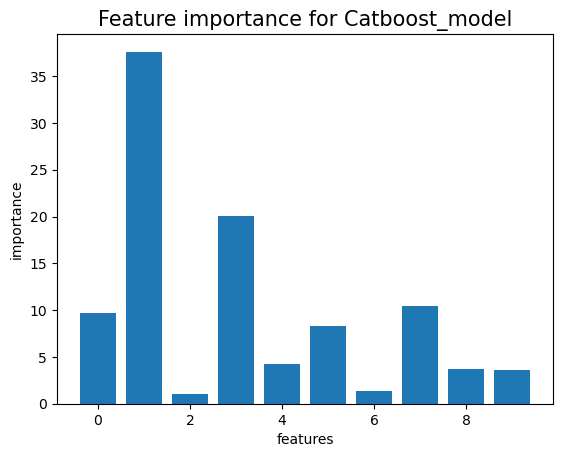

In [167]:
importance_Catboost = Catboost_model.feature_importances_

for i,v in enumerate(importance_Catboost):
    print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance_Catboost))], importance_Catboost)

plt.title(label='Feature importance for Catboost_model', fontsize=15)    
plt.ylabel('importance', fontsize=10)
plt.xlabel('features', fontsize=10)

pyplot.show()

### LGBMRegressor

In [168]:
features_train_lgbm = features_train.copy()

In [169]:
features_valid_lgbm = features_valid.copy()

In [170]:
for col in features_train_lgbm.columns:
    col_type = features_train_lgbm[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_train_lgbm[col] = features_train_lgbm[col].astype('category')

In [171]:
for col in features_valid_lgbm.columns:
    col_type = features_valid_lgbm[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_valid_lgbm[col] = features_valid_lgbm[col].astype('category')

In [172]:
features_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182472 entries, 295603 to 253574
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  182472 non-null  category
 1   reg_year      182472 non-null  int64   
 2   gearbox       182472 non-null  category
 3   power         182472 non-null  float64 
 4   model         182472 non-null  category
 5   kilometer     182472 non-null  int64   
 6   fuel_type     182472 non-null  category
 7   brand         182472 non-null  category
 8   repaired      182472 non-null  category
 9   age_category  182472 non-null  category
dtypes: category(7), float64(1), int64(2)
memory usage: 7.0 MB


In [173]:
features_valid_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60824 entries, 327249 to 244841
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  60824 non-null  category
 1   reg_year      60824 non-null  int64   
 2   gearbox       60824 non-null  category
 3   power         60824 non-null  float64 
 4   model         60824 non-null  category
 5   kilometer     60824 non-null  int64   
 6   fuel_type     60824 non-null  category
 7   brand         60824 non-null  category
 8   repaired      60824 non-null  category
 9   age_category  60824 non-null  category
dtypes: category(7), float64(1), int64(2)
memory usage: 2.3 MB


In [174]:
LGBMRegressor_model = LGBMRegressor(random_state=RS)

In [175]:
LightGBM_params = {'num_trees': [100, 250, 500],
                   'num_leaves': [200, 250, 300],
                   'max_depth': [2, 4, 6, 8],
                   'learning_rate': [0.03, 0.1],}

In [176]:
LGBMRegressor_RS = RandomizedSearchCV(LGBMRegressor_model, param_distributions=LightGBM_params, 
                                         cv=CV, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [177]:
%%time
LGBMRegressor_RS.fit(features_train_lgbm, target_train)

[LightGBM] [Warning] num_iterations is set=250, num_trees=250 will be ignored. Current value: num_iterations=250
CPU times: total: 19.4 s
Wall time: 3min 11s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
                   param_distributions={'learning_rate': [0.03, 0.1],
                                        'max_depth': [2, 4, 6, 8],
                                        'num_leaves': [200, 250, 300],
                                        'num_trees': [100, 250, 500]},
                   scoring='neg_root_mean_squared_error')

In [178]:
LGBMRegressor_RS.best_params_

{'num_trees': 250, 'num_leaves': 300, 'max_depth': 8, 'learning_rate': 0.1}

In [179]:
LGBMRegressor_model = LGBMRegressor(random_state=RS, num_trees=500, num_leaves=250, max_depth=8, learning_rate=0.03)

In [180]:
%%time
LGBMRegressor_model.fit(features_train_lgbm, target_train)

CPU times: total: 41.9 s
Wall time: 15.6 s


LGBMRegressor(learning_rate=0.03, max_depth=8, num_leaves=250, num_trees=500,
              random_state=12345)

In [181]:
%%time
LGBMRegressor_model_predictions = LGBMRegressor_model.predict(features_valid_lgbm)

CPU times: total: 16 s
Wall time: 4.31 s


In [182]:
LGBMRegressor_model_rmse = RMSE(target_valid, LGBMRegressor_model_predictions)
    
print('RMSE:', LGBMRegressor_model_rmse)

RMSE: 1345.5710286454766


Хорошая скорость предсказаний и обучения и хорошие результаты по метрике.

Feature: 0, Score: 3182.00000
Feature: 1, Score: 17248.00000
Feature: 2, Score: 2473.00000
Feature: 3, Score: 16775.00000
Feature: 4, Score: 9061.00000
Feature: 5, Score: 7795.00000
Feature: 6, Score: 1119.00000
Feature: 7, Score: 3540.00000
Feature: 8, Score: 4317.00000
Feature: 9, Score: 223.00000


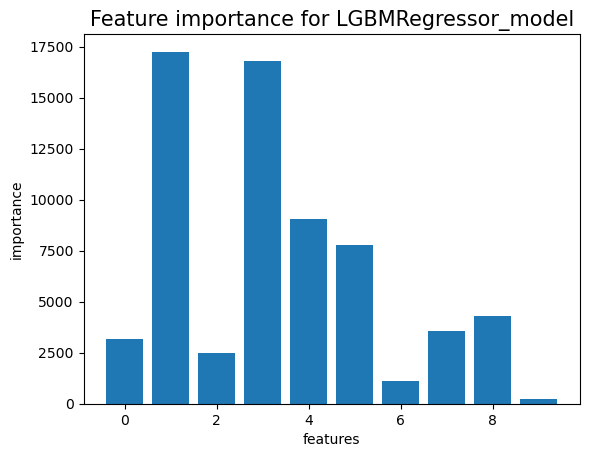

In [183]:
importance_LGBMR = LGBMRegressor_model.feature_importances_

for i,v in enumerate(importance_LGBMR):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
plt.title(label='Feature importance for LGBMRegressor_model', fontsize=15)    
plt.ylabel('importance', fontsize=10)
plt.xlabel('features', fontsize=10)

pyplot.bar([x for x in range(len(importance_LGBMR))], importance_LGBMR)

pyplot.show()

### RandomForestRegressor

In [184]:
RandomForest_model = RandomForestRegressor(random_state=RS, max_depth=8, n_estimators=300, bootstrap=True)

In [185]:
RF_params = {'max_features': ['auto', 'sqrt'],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]}

In [186]:
RandomForest_RS = RandomizedSearchCV(RandomForest_model, param_distributions=RF_params, 
                                         cv=CV, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [187]:
%%time
RandomForest_RS.fit(features_train_oe, target_train)

CPU times: total: 1min 59s
Wall time: 31min 7s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_depth=8,
                                                   n_estimators=300,
                                                   random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='neg_root_mean_squared_error')

In [188]:
RandomForest_RS.best_params_

{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto'}

In [189]:
RandomForest_model = RandomForestRegressor(
    random_state=RS, max_depth=8, n_estimators=300, max_features='sqrt', \
    min_samples_split=3, min_samples_leaf=2, bootstrap=True
)

In [190]:
%%time
RandomForest_model.fit(features_train_oe, target_train)

CPU times: total: 46.7 s
Wall time: 1min 8s


RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=3, n_estimators=300,
                      random_state=12345)

In [191]:
%%time
RandomForest_model_predictions = RandomForest_model.predict(features_valid_oe)

CPU times: total: 2.11 s
Wall time: 3.13 s


In [192]:
RandomForest_model_rmse = RMSE(target_valid, RandomForest_model_predictions)

print('RMSE:', RandomForest_model_rmse)    

RMSE: 1738.8955390078404


Плохая скорость предсказаний и обучения и удовлетворяющие результаты по метрике.

Feature: 0, Score: 0.03019
Feature: 1, Score: 0.44031
Feature: 2, Score: 0.01851
Feature: 3, Score: 0.22734
Feature: 4, Score: 0.00807
Feature: 5, Score: 0.09025
Feature: 6, Score: 0.02378
Feature: 7, Score: 0.02932
Feature: 8, Score: 0.03040
Feature: 9, Score: 0.10182


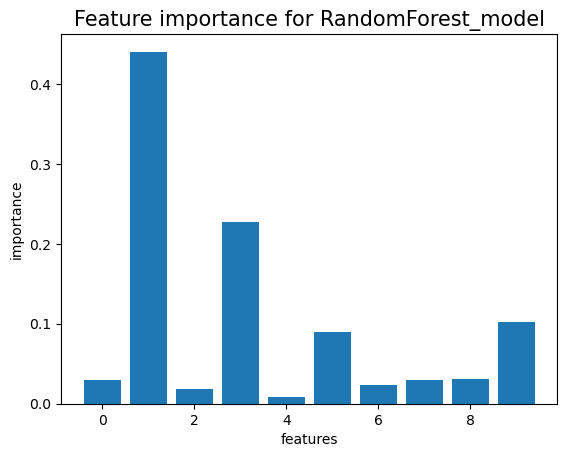

In [193]:
importance_RF = RandomForest_model.feature_importances_

for i,v in enumerate(importance_RF):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
plt.title(label='Feature importance for RandomForest_model', fontsize=15)    
plt.ylabel('importance', fontsize=10)
plt.xlabel('features', fontsize=10)

pyplot.bar([x for x in range(len(importance_RF))], importance_RF)

pyplot.show()

### GradientBoostingRegressor

In [194]:
GBRegressor_model = GradientBoostingRegressor(loss='squared_error', random_state=RS, learning_rate=0.1, max_depth=8)

In [195]:
%%time
GBRegressor_model.fit(features_train_oe, target_train)

CPU times: total: 1min 9s
Wall time: 1min 39s


GradientBoostingRegressor(max_depth=8, random_state=12345)

In [196]:
%%time
GBRegressor_model_predictions = GBRegressor_model.predict(features_valid_oe)

CPU times: total: 391 ms
Wall time: 649 ms


In [197]:
GBRegressor_model_rmse = RMSE(target_valid, GBRegressor_model_predictions)

print('RMSE:', GBRegressor_model_rmse)  

RMSE: 1394.843338621094


Плохая скорость предсказаний и обучения и хорошие результаты по метрике.

Feature: 0, Score: 0.03356
Feature: 1, Score: 0.56291
Feature: 2, Score: 0.00572
Feature: 3, Score: 0.24460
Feature: 4, Score: 0.01905
Feature: 5, Score: 0.05979
Feature: 6, Score: 0.00681
Feature: 7, Score: 0.04417
Feature: 8, Score: 0.02040
Feature: 9, Score: 0.00299


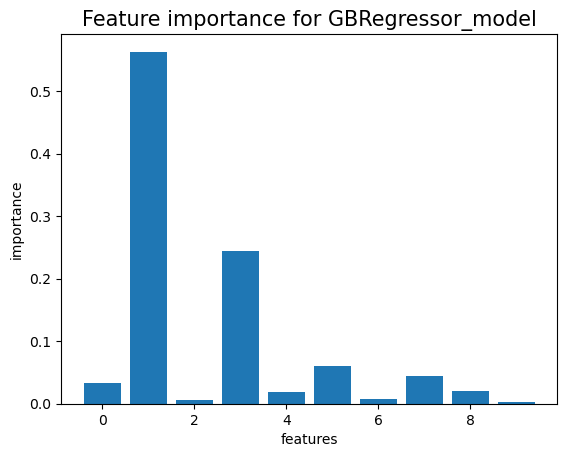

In [198]:
importance_GBR = GBRegressor_model.feature_importances_

for i,v in enumerate(importance_GBR):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.title(label='Feature importance for GBRegressor_model', fontsize=15)    
plt.ylabel('importance', fontsize=10)
plt.xlabel('features', fontsize=10)
    
pyplot.bar([x for x in range(len(importance_GBR))], importance_GBR)

pyplot.show()

### XGBRegressor

In [199]:
XGBRegressor_model = XGBRegressor(random_state=RS, booster='gbtree', eval_metric='rmse', n_estimators=300, 
                                  min_child_weight=3, max_depth=8)

In [200]:
%%time
XGBRegressor_model.fit(features_train_oe, target_train)

CPU times: total: 3min 48s
Wall time: 1min 3s


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=12345, ...)

In [201]:
%%time
XGBRegressor_model_predictions = XGBRegressor_model.predict(features_valid_oe)

CPU times: total: 1.88 s
Wall time: 523 ms


In [202]:
XGBRegressor_model_rmse = RMSE(target_valid, XGBRegressor_model_predictions)

print('RMSE:', XGBRegressor_model_rmse)  

RMSE: 1356.317391087819


Невысокая скорость обучения, быстрое предсказание и отличная метрика.

Feature: 0, Score: 0.05870
Feature: 1, Score: 0.35007
Feature: 2, Score: 0.02633
Feature: 3, Score: 0.15490
Feature: 4, Score: 0.02634
Feature: 5, Score: 0.07758
Feature: 6, Score: 0.02447
Feature: 7, Score: 0.06807
Feature: 8, Score: 0.05695
Feature: 9, Score: 0.15660


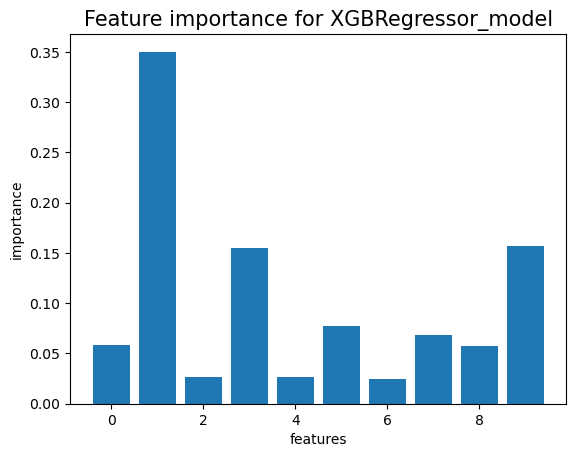

In [203]:
importance_XGBR = XGBRegressor_model.feature_importances_

for i,v in enumerate(importance_XGBR):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
plt.title(label='Feature importance for XGBRegressor_model', fontsize=15)    
plt.ylabel('importance', fontsize=10)
plt.xlabel('features', fontsize=10)

pyplot.bar([x for x in range(len(importance_XGBR))], importance_XGBR)

pyplot.show()

**Промежуточный итог:**

Мы обучили 6 моделей для решения поставленной задачи, далее сравним их и решим, какая подходит нам больше всего с учетом условий заказчика.

## Анализ моделей

In [204]:
models_time = {'LR_model': [LR_model_rmse, 0.07, 0.014, 0, 0.05, 'none'], 
               'Catboost_model': [Catboost_model_rmse, 77, 263, 0.688, 0.397, 5],
               'LGBMRegressor_model': [LGBMRegressor_model_rmse, 42.5, 11.1, 16, 4.1, 5],
               'RandomForest_model': [RandomForest_model_rmse, 49.5, 50.3, 2.19, 2.17, 7],
               'GBRegressor_model': [GBRegressor_model_rmse, 76, 78, 0.5, 0.475, 4],
               'XGBRegressor_model': [XGBRegressor_model_rmse, 171, 45.5, 1.53, 0.553, 6]
              }

In [205]:
df_time = pd.DataFrame(
    data=models_time, 
    index=['RMSE', 'fit_CPU_s', 'fit_WALL_s', 'predict_CPU_s', 'predict_WALL_s', 'params'])

In [206]:
df_time

,LR_model,Catboost_model,LGBMRegressor_model,RandomForest_model,GBRegressor_model,XGBRegressor_model
RMSE,1686.939399,1420.39066,1345.571029,1738.895539,1394.843339,1356.317391
fit_CPU_s,0.07,77.00000,42.500000,49.500000,76.000000,171.000000
fit_WALL_s,0.014,263.00000,11.100000,50.300000,78.000000,45.500000
predict_CPU_s,0,0.68800,16.000000,2.190000,0.500000,1.530000
predict_WALL_s,0.05,0.39700,4.100000,2.170000,0.475000,0.553000
params,none,5.00000,5.000000,7.000000,4.000000,6.000000


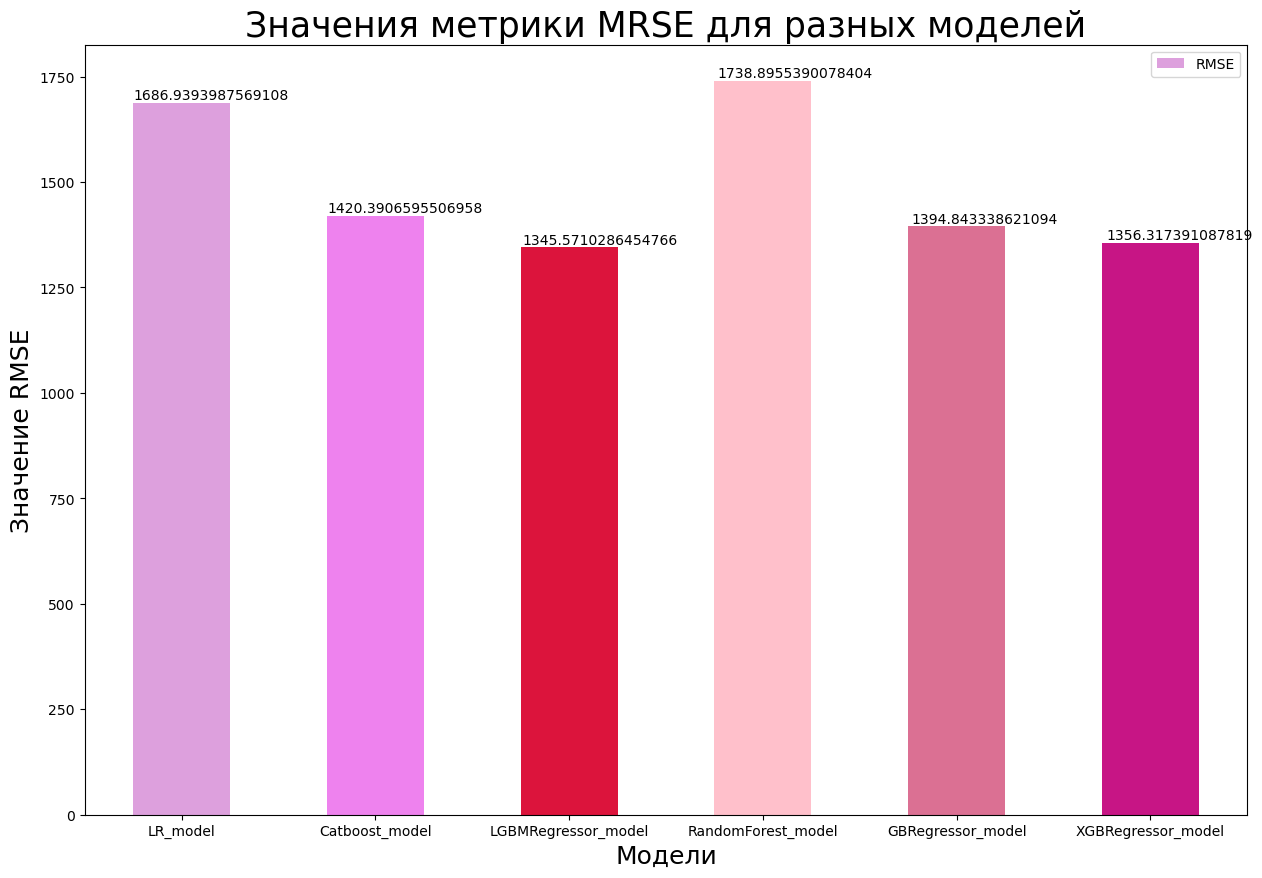

In [207]:
my_colors = ['plum', 'violet', 'crimson', 'pink', 'palevioletred', 'mediumvioletred']

fig = plt.figure(figsize=(15,10))

ax = df_time.iloc[0].plot(kind='bar', rot=0, legend='reverse', color=my_colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
plt.title(label='Значения метрики MRSE для разных моделей', fontsize=25)    
plt.ylabel("Значение RMSE", fontsize=18)
plt.xlabel("Модели", fontsize=18)

plt.show()

Худшие результаты по метрике показали модели случайного леса и линейной регрессии, лучшие - модель с алгоритмом LGBMRegressor. Также хорошие, почти наравне с LGBMR, значения показала модель алгоритма XGBoostRegressor.

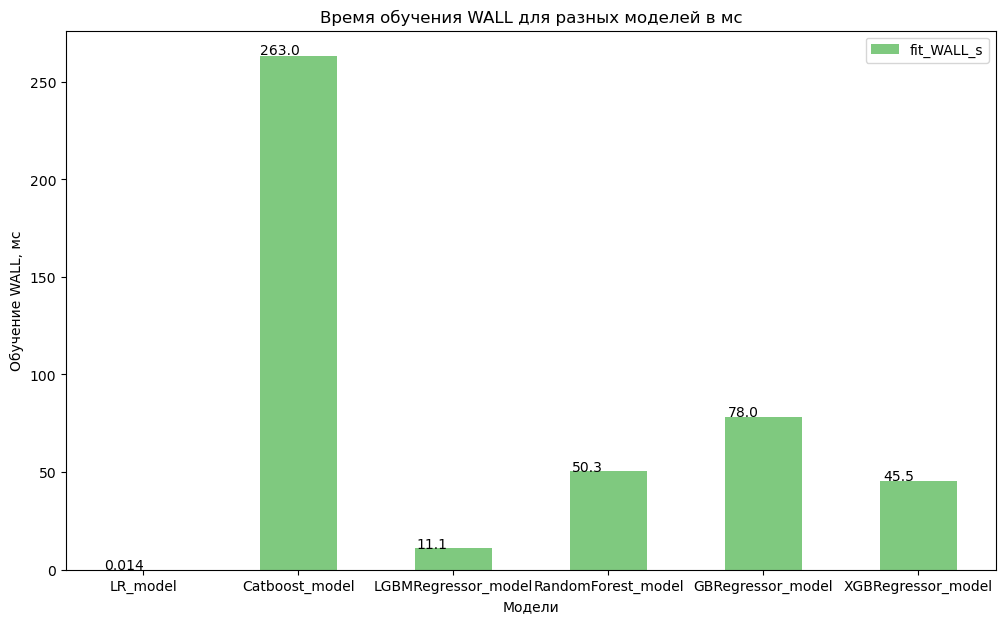

In [208]:
fig = plt.figure(figsize=(12,7))

ax = df_time.iloc[2].plot(kind='bar', title='Время обучения WALL для разных моделей в мс', rot=0,
                          legend='reverse', colormap='Accent')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.ylabel("Обучение WALL, мс")
plt.xlabel("Модели")

plt.show()

Быстрее всего обучается модель лин.регрессии, затем - LGBMRegressor. Дольше всех обучается модель с алгоритмом CatBoostRegressor.

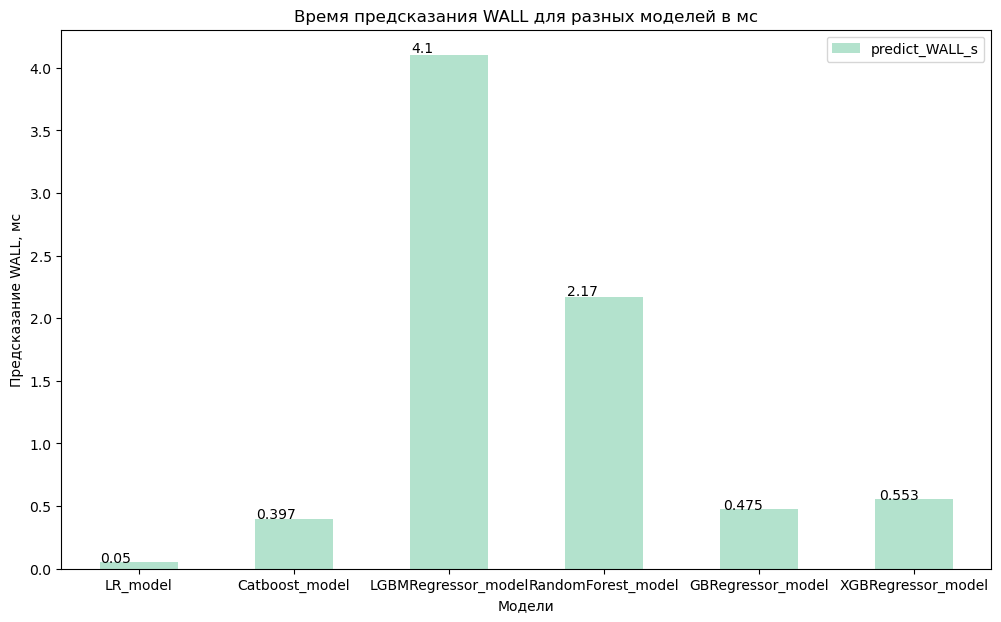

In [209]:
fig = plt.figure(figsize=(12,7))

ax = df_time.iloc[4].plot(kind='bar', title='Время предсказания WALL для разных моделей в мс', rot=0,
                          legend='reverse', colormap='Pastel2')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
plt.ylabel("Предсказание WALL, мс")
plt.xlabel("Модели")

plt.show()

LGBMRegressor здесь показала наихудшие результаты, хотя разница с другими составляет 3 сек.

Заетим, что по скорости обучения у модели LGBMRegressor разница до трех минут в её пользу.

**В качестве лучшей модели выберем** модель LGBMRegressor, тк она:
1. Отличается практически лучшей метрико RMSE
2. Обучается быстрее всех других моделей
Быстрота предсказаний не лучшая(и разница относительно не большая), но другие модели проигрывают перед LGBMRegressor по другим критериям.

## Проверка лучшей модели

**Сравнение с дамми моделью**

In [210]:
dummy_model = DummyRegressor()

In [211]:
dummy_model.fit(features_train_oe, target_train)

DummyRegressor()

In [212]:
dummy_predictions = dummy_model.predict(features_test_oe)

In [213]:
dummy_rmse = RMSE(target_test, dummy_predictions)

print('RMSE:', dummy_rmse)  

RMSE: 3718.140341588805


RMSE у нашей модели ниже требуемого порога и уж явно ниже метрики дамми модели.

**Проверка метрики на тестовых данных**

In [214]:
features_test_lgbm = features_test.copy()

In [215]:
for col in features_test_lgbm.columns:
    col_type = features_test_lgbm[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_test_lgbm[col] = features_test_lgbm[col].astype('category')

In [216]:
%%time
test_predictions = LGBMRegressor_model.predict(features_test_lgbm)

CPU times: total: 21.4 s
Wall time: 6.97 s


In [217]:
test_rmse = RMSE(target_test, test_predictions)

print('RMSE:', test_rmse)

RMSE: 1339.8433084935448


Модель показывает ещё более хорошую метрику на тесовых данных. 

**Проверка модели на адекватность и качество работы пройдена.**

## Итоги работы

С первым знакомством с данными были обнаружены некоторые проблемы: пропуски, неинформативные признаки, аномальные значения и выбросы. Данные обработали: там, где это возможно, заполнили пропуски, где нет - поставили заглушки, а также избавились от выбросов и аномалий.

Добавили новый категориальный столбец с типом возраста автомобиля.

Подготовили выборки и для моделей, которые работают с категориальными данными, и для моделей, которым требуется кодировка; не использовали неинформативные признаки.

Обучили 6 моделей, используя RandomizedSearchCV для поиска лучших гиперпараметров. Работали со следующими алгоритмами:
- LinearRegression
- RandomForestRegressor
- GradientBoostingRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBoostRegressor

Отличные результаты по метрике показали модели GradientBoostingRegressor, XGBoostRegressor и LGBMRegressor, но если учитывать скорость обучения и предсказания, то лучшей моделью является модель с алгоритмом LGBMRegressor.

Данная модель прошла проверку на адекватность, соответствует поставленным заказчиком условиям и показывает хорошие результаты на тестовой выборке.